# Create meaningful embeddings using node2vec 
* skip-gram: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* word2vec vs. node2vec
* node2vec: sampling 
  * number of walks: # of random walks to be generated from each node
  * walk length: how many nodes are in each random walk
  * P: return hyperparam
  * Q: inout hyperparam 


In [112]:
# use node2vec to blind posts 
# each post has a original poster with employer flagged (nodes)
# the post talks about own employer, as well as other companies 
# own employer - company edges 
 
# node2vec algo
# grover & leskovec 2016 scalable feature learning for networks
from node2vec import Node2Vec


import os 
from pathlib import Path 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


# generate graph 
import networkx as nx
from tqdm import tqdm
from collections import defaultdict
import math

# info
import warnings
warnings.filterwarnings('ignore')


In [57]:
# set seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(1234)


In [24]:
# load data
file_path = f'{str(Path(os.getcwd()).parent)}/datafiles/blindPosts/'  # original csvs separated by company
print(f'---reading raw files from {file_path}---')
files = [file_path + f for f in os.listdir(file_path)]
df = pd.concat([pd.read_csv(f, parse_dates=True).iloc[:, 1:]
                for f in files])  # concat all csvs

# prepare data
df = df.rename({'post_like': 'likes', 'post_comment': 'comments'}, axis=1)
df['post_firm'] = df['post_firm'].map(lambda x: str(
    x).replace('/company/', '').rstrip('/'))  # op's employer
df['likes'] = df['likes'].map(lambda x: str(x).replace(',', ''))  # of likes
df['comments'] = df['comments'].map(
    lambda x: str(x).replace(',', ''))  # of comments

# change data types
df['likes'] = pd.to_numeric(df['likes'])
df['comments'] = pd.to_numeric(df['comments'])
df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])
df = df.reset_index().set_index(
    ['company', 'post_timestamp']).sort_index().reset_index()
df = df[~df['post_text'].duplicated()]
df = df[['company', 'post_firm', 'likes', 'comments']]

---reading raw files from /Users/fangfeishu/Projects/advancedNLP/datafiles/blindPosts/---


### Step 1: Create weighted edges between companies

In [34]:
# Construct the companies graph 
min_likes = df.likes.quantile(0.95)  
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Optional: filter instances where likes or comments are too low 
liked_posts = df[df.likes > min_likes]
# Group instances by user.
posts_groupby_usercompany = list(liked_posts.groupby("post_firm"))
for group in tqdm(
    posts_groupby_usercompany,
    position=0,
    leave=True,
    desc="Compute post likes frequencies ",
):
    # Get a list of movies rated by the user.
    out_company = list(group[1]["company"])

    for i in range(len(out_company)):
        item_frequency[out_company[i]] += 1
        for j in range(i + 1, len(out_company)):
            x = min(out_company[i], out_company[j])
            y = max(out_company[i], out_company[j])
            pair_frequency[(x, y)] += 1

Compute post likes frequencies : 100%|██████████| 614/614 [00:03<00:00, 177.97it/s]


### Step 2: Create the graph with the nodes and the edges

In [49]:
# to reduce the edges between nodes, we only add an edge between companies if the weight
# of the edge is greater than `min_weight`

min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
company_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the company graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        company_graph.add_edge(x, y, weight=weight)

Creating the company graph: 100%|██████████| 24262/24262 [00:00<00:00, 159433.91it/s]


In [50]:
print("Total number of graph nodes:", company_graph.number_of_nodes())
print("Total number of graph edges:", company_graph.number_of_edges())

Total number of graph nodes: 298
Total number of graph edges: 18384


In [51]:
degrees = []
for node in company_graph.nodes:
    degrees.append(company_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 123.38


### Step 3: Create a vocabulary and a mapping from tokens to int indices

In [44]:
vocabulary = ["NA"] + list(company_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## Implement the biased random walk

In [52]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [58]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(company_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 298/298 [00:04<00:00, 60.72it/s]

Number of walks generated: 1490


In [61]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 1490/1490 [00:06<00:00, 232.40it/s]


In [62]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (53045,)
Contexts shape: (53045,)
Labels shape: (53045,)
Weights shape: (53045,)


In [63]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## Train the skip-gram model

In [64]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [65]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

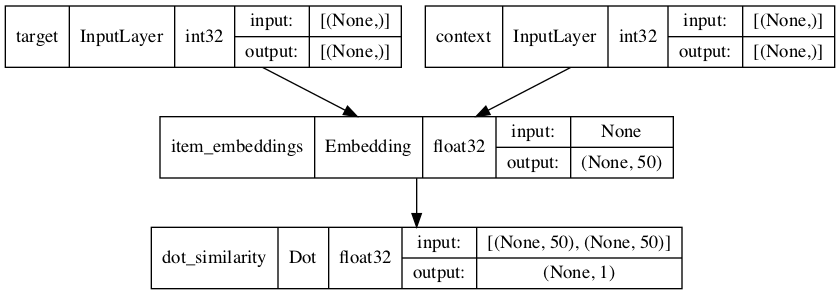

In [66]:
keras.utils.plot_model(
    model, show_shapes=True, show_dtype=True, show_layer_names=True,
)

In [67]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
51/51 [==============================] - 3s 16ms/step - loss: 8.8208
Epoch 2/10
51/51 [==============================] - 1s 14ms/step - loss: 8.8042
Epoch 3/10
51/51 [==============================] - 1s 20ms/step - loss: 8.7828
Epoch 4/10
51/51 [==============================] - 1s 19ms/step - loss: 8.7475
Epoch 5/10
51/51 [==============================] - 1s 19ms/step - loss: 8.6863
Epoch 6/10
51/51 [==============================] - 1s 19ms/step - loss: 8.5911
Epoch 7/10
51/51 [==============================] - 1s 15ms/step - loss: 8.4558
Epoch 8/10
51/51 [==============================] - 1s 16ms/step - loss: 8.2866
Epoch 9/10
51/51 [==============================] - 1s 13ms/step - loss: 8.1125
Epoch 10/10
51/51 [==============================] - 1s 15ms/step - loss: 7.9571


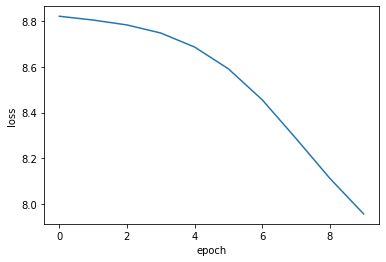

In [68]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [72]:
company_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", company_embeddings.shape)

Embeddings shape: (299, 50)


In [93]:


query = [
    "Postmates",
    "DoorDash",
    "Facebook",
    "Qualcomm",
]

query_embeddings = []

for company in query:
    token_id = vocabulary_lookup[company]
    company_embedding = company_embeddings[token_id]
    query_embeddings.append(company_embedding)

query_embeddings = np.array(query_embeddings)

In [94]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(company_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=10)
indices = indices.numpy().tolist()

In [95]:
for idx, title in enumerate(query):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_id = vocabulary[token]
        print(f"- {similar_id}")
    print()

Postmates
---------
- Postmates
- Porsche
- Bank-of-the-West
- Fanatics
- Macys
- BlueJeans
- GoDaddy
- IEEE
- KPMG
- BCG-Digital-Ventures

DoorDash
--------
- DoorDash
- Facebook
- Citi
- Booking.com
- Airbnb
- Google
- Microsoft
- UPS
- Travelers
- Robinhood

Facebook
--------
- Facebook
- Amazon
- Booking.com
- Google
- Move
- Citi
- Robinhood
- Airbnb
- Microsoft
- Visa

Qualcomm
--------
- Qualcomm
- IEEE
- ServiceNow
- CA-Technologies
- BCG-Digital-Ventures
- Macys
- NortonLifeLock
- Mastercard
- Druva
- Palo-Alto-Networks



## Node2Vec algorithm

In [98]:
node2vec = Node2Vec(company_graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

Computing transition probabilities: 100%|██████████| 298/298 [00:56<00:00,  5.31it/s]


In [101]:
model = node2vec.fit(window=10, min_count=1)

In [114]:
for node, _ in model.most_similar('Coinbase'):
    print(node)

State-Farm
Morningstar
Grubhub
AQR
ABB
Instacart
McKinsey
Just-Energy
Auth0
Citi
